In [1]:
import time
import os
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats, wcs
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy
import photutils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/61_inch/20181219/

/Users/tim/MMT/61_inch/20181219


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [5]:
extra_whole = fits.open("rts2focus0012.fits")[1].data # focus = 3190
intra_whole = fits.open("rts2focus0017.fits")[1].data # focus = 1992
#intra = intra_whole[942-18:942+18,158-18:158+18] - np.median(intra_whole)
#extra = extra_whole[945-18:945+18,154-18:154+18] - np.median(extra_whole)
intra = intra_whole[780-35:780+35,503-35:503+35] - np.median(intra_whole)
extra = extra_whole[780-35:780+35,509-35:509+35] - np.median(extra_whole)

<IPython.core.display.Javascript object>


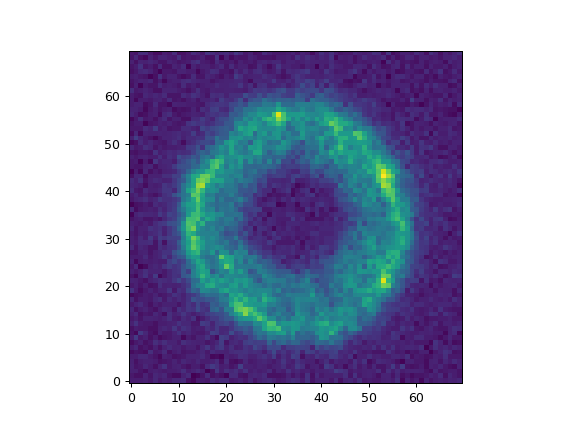

In [6]:
#plt.imshow(intra_whole[942-20:942+20,158-20:158+20], origin="lower")
#plt.imshow(extra_whole[945-20:945+20,154-20:154+20], origin="lower")
plt.imshow(intra, origin="lower")
plt.show()

<IPython.core.display.Javascript object>


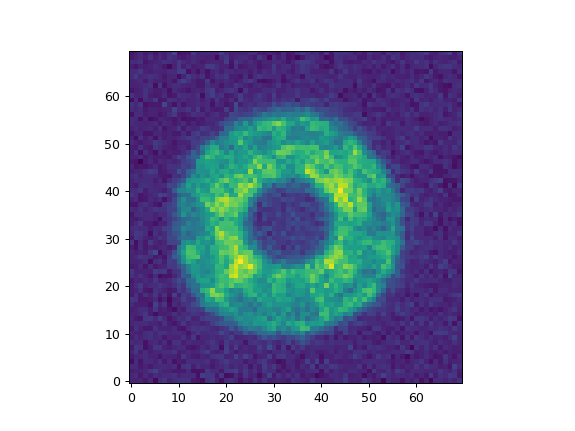

In [7]:
plt.imshow(extra, origin="lower")
plt.show()

In [8]:
fits.writeto("intra.fits", intra, overwrite=True)
fits.writeto("extra.fits", extra, overwrite=True)

These images are binned 3x3 so the pixels are 42 um. Thus the pupil diameter is:

In [9]:
pupsize = 25.25 * 3 * 14
pupsize * u.um

<Quantity 1060.5 um>

The mirror diameter is 1.54 meters and the focal ratio is 13.5. So the focal length is:

In [10]:
diameter = 1.54 * u.m
radius = diameter / 2.
focal_length = diameter * 13.5
focal_length

<Quantity 20.79 m>

Calculate the angle of beam convergence:

In [11]:
ang = np.arctan2(radius, focal_length)
ang

<Quantity 0.03702012 rad>

In [12]:
offset = pupsize / np.tan(ang) * u.um
offset

<Quantity 28633.5 um>

In [13]:
def kuiper_focus(pup_rad, focus, binning=3, direction='out'):
    pupsize = 14 * binning * pup_rad * u.um
    diameter = 1.54 * u.m
    radius = diameter / 2
    focal_length = diameter * 13.5
    beam_ang = np.arctan2(radius, focal_length)
    offset = pupsize / np.tan(beam_ang) * u.um
    counts_per_um = 600. / 28633.5  # empirically determined
    correction = offset.value * counts_per_um
    if 'out' in direction:
        correction *= -1
    return focus + correction

In [14]:
kuiper_focus(25.25, 3190, direction='out')

2590.0

So about 14 mm of focus offset at focal plane for 300 counts of focus change which gives 20 counts/mm. For motion at the secondary, scale by the ratio of the squares of the focal ratios:

In [14]:
counts_per_mm = 600. / offset.to(u.mm).value
counts_per_mm_m2 = counts_per_mm / (13.5**2 / 4.**2)
counts_per_mm, counts_per_mm_m2

(20.954476400020955, 1.8396248142679577)

In [15]:
obscuration = 0.4096 / 1.54
obscuration

0.265974025974026

In [16]:
nmperrad = radius.to(u.nm).value
nmperasec = nmperrad / 206265.
nmperasec

3733.061837926938

In [17]:
fieldXY = [0., 0.]
I1 = Image(readFile("intra.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("extra.fits"), fieldXY, Image.EXTRA)

<IPython.core.display.Javascript object>


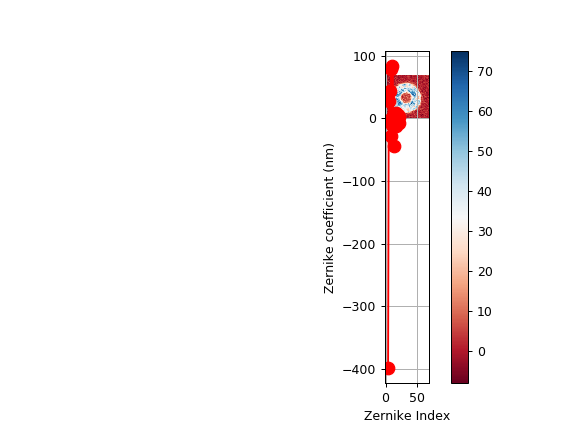

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(I2.image, origin='lower', cmap='RdBu')
cbar = fig.colorbar(im)
fig.show()

In [19]:
kuiper = Instrument('61inch', I1.sizeinPix)

In [20]:
#kuiper.offset = offset.to(u.m).value  # needs to be focus offset between intra and extra positions
kuiper.offset

0.028634

In [21]:
algo = Algorithm('exp', kuiper, 3)

In [22]:
algo.runIt(kuiper, I1, I2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   35.43,   35.70)

imageCoCenter: (x1,y1)=(   34.23,   34.72)

itr = 0, z4-z22
[-407.   -1.   19.   46.  -19.   61.    1.   76.    2.    2.  -27.    1.
    3.  -11.   -3.   -3.    3.   -4.    6.]
itr = 1, z4-z22
[-459.    3.   37.   34.  -16.   55.   11.   76.    0.    1.  -28.   -3.
    4.   -7.   -4.   -3.    2.   -4.   -5.]
itr = 2, z4-z22
[-490.    7.   49.   32.  -11.   50.   15.   75.   -1.    1.  -30.   -2.
    3.   -6.   -4.   -3.    1.   -5.  -10.]
itr = 3, z4-z22
[-520.   -1.   68.   37.   -8.   48.   19.   76.   -1.    1.  -28.    0.
    2.  -11.   -4.   -3.   -2.   -7.  -13.]
itr = 4, z4-z22
[-529.   -3.   74.   53.   -7.   48.   20.   75.    1.    2.  -28.    1.
    1.  -18.   -5.   -4.   -2.   -5.  -15.]
itr = 5, z4-z22
[-467.    1.   52.   48.  -12.   67.   14.   79.    3.    2.  -29.   -1.
    2.  -14.   -3.   -3.    1.   -3.  -10.]
itr = 6, z4-z22
[-446.    5.   50.   32.  -14.   70.   14.   82.    3.    1.  -29.   -

In [23]:
print(algo.zer4UpNm)

[-398.86341878   -1.89762918   28.58747288   44.45340701  -28.04819068
   79.56051583   -9.70980505   83.82882587    3.21713523    2.41049763
  -43.82220524    1.88982262    9.07378825  -11.32360352   -2.75342198
    0.59218874    5.02961477   -6.98246943    1.65217777]


In [24]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [25]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()
zv

Fringe Coefficients
 Z04:                -690.9 nm 	 Defocus (2, 0)
 Z05:                -4.648 nm 	 Primary Astig at 45° (2, -2)
 Z06:                 70.02 nm 	 Primary Astig at 0° (2, 2)
 Z07:                 125.7 nm 	 Primary Y Coma (3, -1)
 Z08:                -79.33 nm 	 Primary X Coma (3, 1)
 Z09:                   225 nm 	 Y Trefoil (3, -3)
 Z10:                -27.46 nm 	 X Trefoil (3, 3)
 Z11:                 187.4 nm 	 Primary Spherical (4, 0)
 Z12:                 10.17 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                 7.623 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                -138.6 nm 	 X Tetrafoil (4, 4)
 Z15:                 5.976 nm 	 Y Tetrafoil (4, -4)
 Z16:                 31.43 nm 	 Secondary X Coma (5, 1)
 Z17:                -39.23 nm 	 Secondary Y Coma (5, -1)
 Z18:                -9.538 nm 	 Secondary X Trefoil (5, 3)
 Z19:                 2.051 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 17.42 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


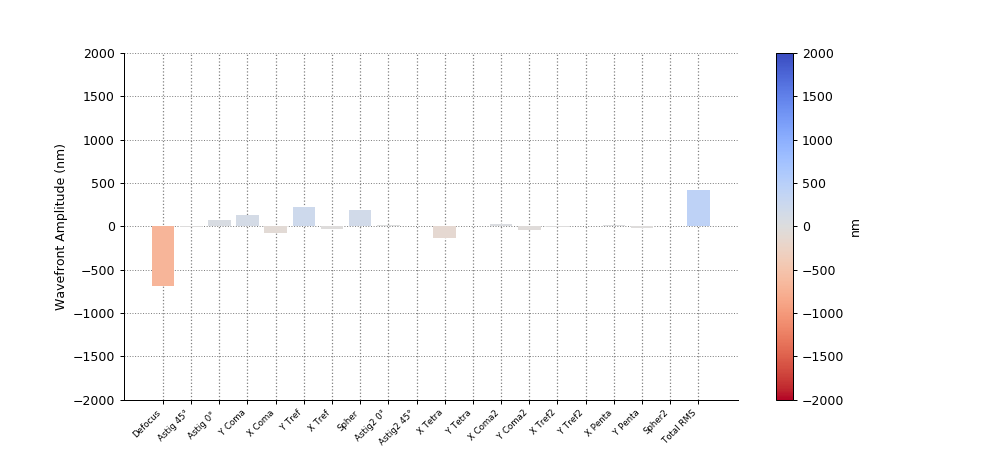

In [26]:
zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


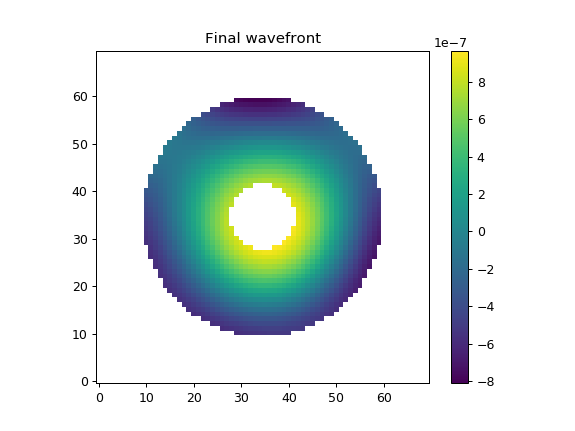

In [27]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

<IPython.core.display.Javascript object>


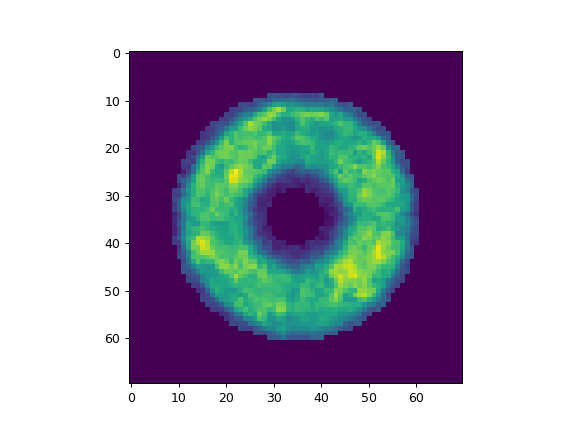

In [28]:
plt.imshow(algo.image)
plt.show()

In [ ]:
plt.close('all')

Scaling seems wrong so try to calculate offset for MMT same way...

In [ ]:
pupsize = 135. * 26.
diameter = 6.5 * u.m
radius = diameter / 2.
focal_length = diameter * 5.3
ang = np.arctan2(radius, focal_length)
offset = 0.5 * pupsize / np.tan(ang) * u.um
offset

OK, this matches what we're using there.

Use the Z04 term from the CWFS fit and see if we can calculate a focus correction

In [118]:
# this calculates the difference in size between in-focus pupil and observed in um
foc_err = (zv['Z04'] / (nmperasec * u.nm / u.arcsec)) * (100 * u.um / u.arcsec)

# use the tangent of the beam angle to convert pupil size difference to shift in focus position at focal plane.
# convert to focus counts and negate to create correction to send to telescope.
foc_corr = -counts_per_mm * foc_err.to(u.mm).value / np.tan(ang)
foc_corr

<Quantity 10.47032659>

In [29]:
hdulist = fits.open("rts2focus0012.fits")

In [30]:
h = hdulist[0].header
h['EPOCH'] = float(h['EPOCH'])
h['EQUINOX'] = float(h['EQUINOX'])
w1 = wcs.WCS(hdulist[1].header)
w2 = wcs.WCS(hdulist[2].header)

In [31]:
w1

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 120.8796666666667  27.79427777777778  
CRPIX : 682.3333333333334  682.3333333333334  
CD1_1 CD1_2  : 0.000119166  -0.0  
CD2_1 CD2_2  : 0.0  0.000119166  
NAXIS : 702  1365

In [32]:
w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 120.8796666666667  27.79427777777778  
CRPIX : 681.3333333333334  682.3333333333334  
CD1_1 CD1_2  : -0.000119166  -0.0  
CD2_1 CD2_2  : -0.0  0.000119166  
NAXIS : 702  1365

In [33]:
hdulist[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  702                                                  
NAXIS2  =                 1365                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'IM1     '           / extension name                                 
BZERO   =              32768.0                                                  
BSCALE  =                  1.0                                                  
INHERIT =                    T / Extension inherits PHDU keyword/values?        
BUNIT   = 'ADU     '           / Physical unit of array values                  
COMMENT ====================

In [34]:
hdulist.info()

Filename: rts2focus0012.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     100   ()      
  1  IM1           1 ImageHDU        71   (702, 1365)   int16 (rescales to uint16)   
  2  IM2           1 ImageHDU        71   (702, 1365)   int16 (rescales to uint16)   


<IPython.core.display.Javascript object>


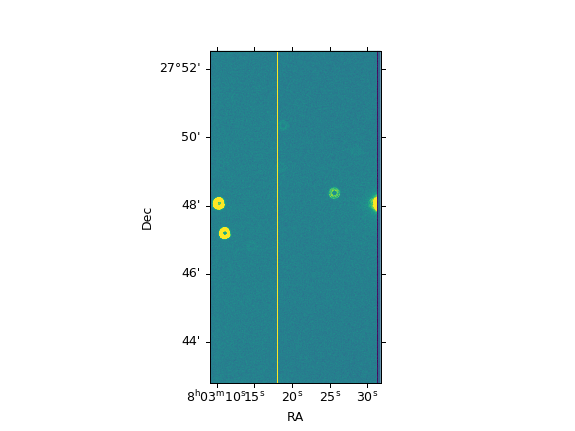

In [35]:
hdu = hdulist[1]
w = wcs.WCS(hdu.header)
im = hdu.data
norm = wfs_norm(im)
plt.subplot(projection=w)
plt.imshow(im, origin='lower', norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [36]:
threshold = photutils.detect_threshold(im, snr=2)
sigma = 10 * stats.gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=15, y_size=15)
kernel.normalize()
segm = photutils.detect_sources(im, threshold, npixels=25, filter_kernel=kernel)

<IPython.core.display.Javascript object>


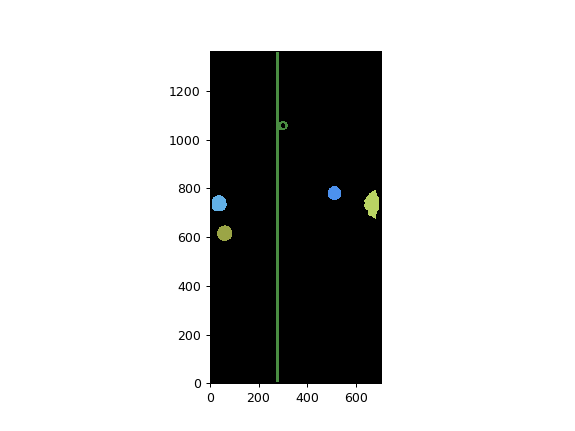

In [37]:
plt.imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
plt.show()